In [19]:
import math
import random
import numpy as np
import torch 
import torch.optim as optim
import torch.nn as nn
from copy import deepcopy
import asyncio
import nest_asyncio
from HP2D_Env import HP2D
from lattice2d_linear_env import Lattice2DLinearEnv
from MCTS import MCTS
from MCTSS import MCTSS, MCTSNode
from models import DualRes
from tqdm import tqdm
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
nest_asyncio.apply()

In [2]:
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Using GPU: GPU requested and available.")
    dtype = torch.cuda.FloatTensor
    dtypelong = torch.cuda.LongTensor
else:
    print("NOT Using GPU: GPU not requested or not available.")
    dtype = torch.FloatTensor
    dtypelong = torch.LongTensor

Using GPU: GPU requested and available.


In [3]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, prob, value):
        state = np.expand_dims(state, 0)
        self.buffer.append((state, prob, value))

    def sample(self, batch_size):
        state, prob, value = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), prob, value

    def __len__(self):
        return len(self.buffer)
    
replay_size = 60000
replay_buffer = ReplayBuffer(replay_size)

In [4]:
dualres = DualRes(10, 4, USE_CUDA)
best_player = deepcopy(dualres)

if USE_CUDA:
    dualres = dualres.cuda()
    best_player = best_player.cuda()

In [5]:
test_model = DualRes(10, 4, USE_CUDA, blocks_sizes = [128], deepths = [2])
if USE_CUDA:
    test_model = test_model.cuda()
    
# Load pretrained params
test_model.load_state_dict(torch.load('test_model_pretrained.pt'))

<All keys matched successfully>

In [6]:
class AlphaLoss(nn.Module):
    def __init__(self):
        super(AlphaLoss, self).__init__()
        
    def forward(self, pred_v, v, pred_p, p):
        ve = nn.MSELoss(reduction = 'none')
        v_err = ve(pred_v.view(-1), v)
        p_err = torch.sum((-p * (1e-15 + pred_p).log()), dim = 1)
        tot_err = (v_err + p_err).mean()
        return tot_err

In [7]:
def compute_loss(net, batch_size, replay_buffer, optimizer, criterion):
    state, p, v = replay_buffer.sample(batch_size)
    state = torch.tensor(np.float32(state)).type(dtype)
    p = torch.tensor(np.float32(p)).type(dtype)
    v = torch.tensor(v).type(dtype)
    
    pred_p, pred_v = net(state)
    loss = criterion(pred_v, v, pred_p, p)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [8]:
def hard_update(q_network, target_q_network):
    for t_param, param in zip(target_q_network.parameters(), q_network.parameters()):
        if t_param is param:
            continue
        new_param = param.data
        t_param.data.copy_(new_param)

In [28]:
file = open('seqs.txt', 'r')
seq_list = file.readlines()
max_length = 5
# Get sequences with length <= max_length
seqs = [s for s in seq_list if len(s) <= max_length + 1]
test_seqs = random.sample(seqs, len(seqs) // 10)
train_seqs = [s for s in seqs if s not in test_seqs]

In [29]:
len(seqs)

48

## Pretrain

In [ ]:
# Fill replay buffer (training on sequences with length <= 15)
ss = [s for s in seq_list if len(s) <= 16]
for seq in tqdm(ss):
    root = MCTSNode(())
    mcts = MCTSS(seq[:-1], 300, (10,11,11))
    mcts.get_prob(root)
    data = mcts.get_data(root)
    for i in range(len(data)):
        replay_buffer.push(data[i][0], data[i][1], data[i][2])

In [ ]:
# Train using pregenerated data, not neural net MCTS
criterion = AlphaLoss()
optimizer = optim.Adam(test_model.parameters(), lr = 0.001)
losses = []

# 10000 Epochs, 10 updates per epoch, batch size 32
for ts in tqdm(range(10000)):
    for _ in range(10):
        if len(replay_buffer) > 32:
            loss = compute_loss(test_model, 32, replay_buffer, optimizer, criterion)
            losses.append(loss)

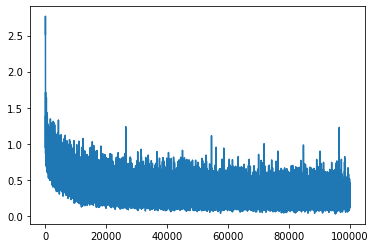

In [13]:
plt.plot(losses)

PHPPHHPPHPHHP
[((5, 5), 'P'), ((5, 4), 'H'), ((5, 3), 'P'), ((6, 3), 'P'), ((6, 4), 'H'), ((7, 4), 'H'), ((7, 3), 'P'), ((8, 3), 'P'), ((8, 4), 'H'), ((8, 5), 'P'), ((9, 5), 'H'), ((9, 6), 'H'), ((9, 7), 'P')]
0.3333333333333333


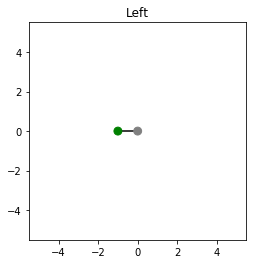

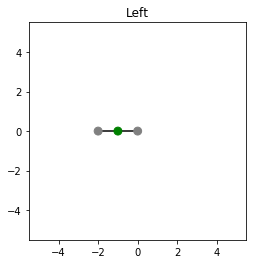

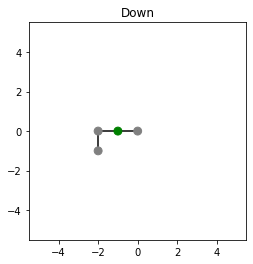

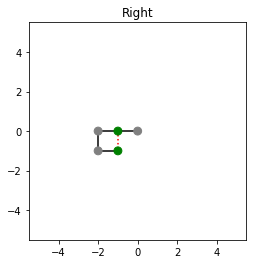

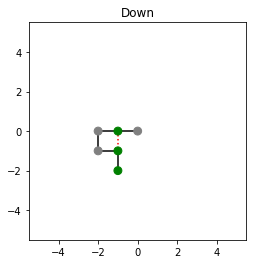

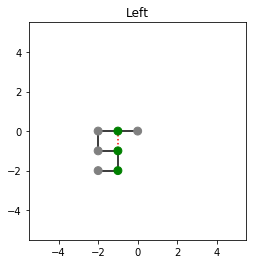

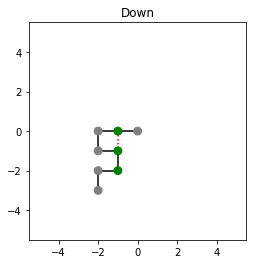

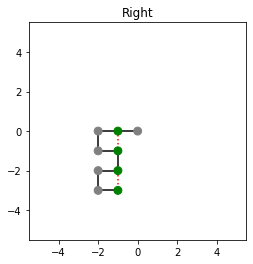

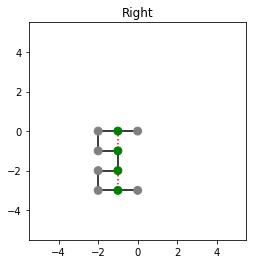

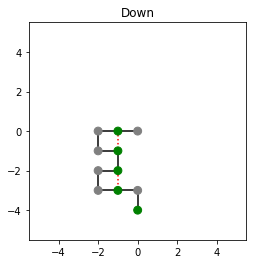

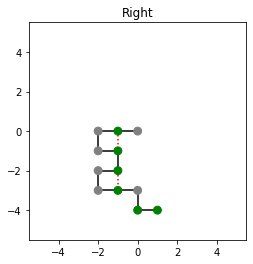

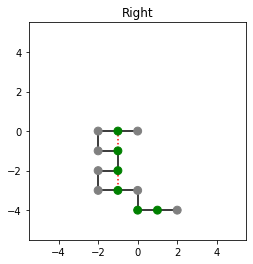

In [21]:
# Test pretrained model

seq = random.sample(seqs, 1)[0][:-1]
print(seq)
env = HP2D(seq, (10,11,11))
tenv = Lattice2DLinearEnv(seq)
tstate = tenv.reset()
state = env.make_state()
for t in range(len(seq) - 1):
    mcts   = MCTS(env, test_model, 300, cpuct = 5)
    pi     = mcts.get_prob(state, temp = 0)
    action = np.random.choice(len(pi), p = pi)
    state  = env.next_state(state, action)
    tenv.step(action)
    tenv.render()
print(env.calc_score(state))

In [22]:
# Save pretrained model parameters
torch.save(test_model.state_dict(), 'test_model_pretrained.pt')

In [31]:
testenv = HP2D('HPPH', (10, 11, 11))
teststate = testenv.make_state()
testpi, testv = test_model.predict(teststate)
print(testpi, testv)
teststate = testenv.next_state(teststate, 0)
testpi, testv = test_model.predict(teststate)
print(testpi, testv)
teststate = testenv.next_state(teststate, 1)
testpi, testv = test_model.predict(teststate)
print(testpi, testv)
teststate = testenv.next_state(teststate, 3)
testpi, testv = test_model.predict(teststate)
print(testpi, testv)

[9.9643010e-01 3.5262038e-03 2.4940984e-05 1.8776973e-05] [0.45022777]
[4.5815632e-03 9.9503034e-01 3.8795455e-04 2.0108185e-07] [0.46705297]
[1.1544039e-17 9.2828685e-07 4.9035765e-13 9.9999905e-01] [0.5388973]
[2.2049408e-08 9.8436689e-01 6.9276906e-10 1.5633130e-02] [0.60373914]


[((5, 5), 'H'), ((5, 4), 'P'), ((4, 4), 'H'), ((4, 5), 'H'), ((3, 5), 'P')]
0.5
[((5, 5), 'H'), ((5, 4), 'H'), ((6, 4), 'P'), ((7, 4), 'P'), ((7, 3), 'P')]
0.0
[((5, 5), 'H'), ((5, 4), 'H'), ((6, 4), 'H'), ((6, 5), 'H'), ((6, 6), 'P')]
0.25
[((5, 5), 'P'), ((5, 4), 'P'), ((4, 4), 'P'), ((4, 3), 'P'), ((4, 2), 'P')]
0
[((5, 5), 'H'), ((5, 4), 'H'), ((5, 3), 'H'), ((6, 3), 'H'), ((6, 4), 'H')]
0.25
[((5, 5), 'H'), ((5, 4), 'P'), ((6, 4), 'H'), ((6, 5), 'P')]
0
[((5, 5), 'H'), ((5, 4), 'P'), ((5, 3), 'P'), ((6, 3), 'H'), ((6, 2), 'H')]
0.0
[((5, 5), 'P'), ((5, 4), 'H'), ((5, 3), 'H'), ((4, 3), 'H')]
-0.5
[((5, 5), 'P'), ((5, 4), 'P'), ((4, 4), 'P'), ((3, 4), 'H')]
0
[((5, 5), 'H'), ((5, 4), 'H'), ((5, 3), 'H'), ((6, 3), 'P'), ((6, 4), 'H')]
0.5


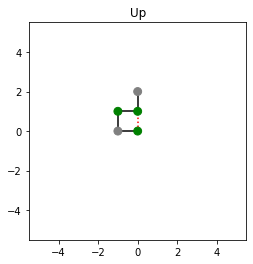

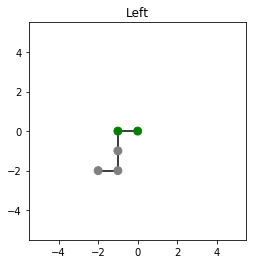

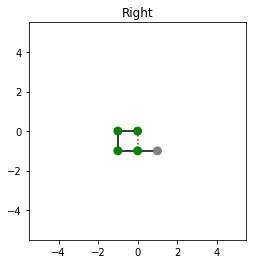

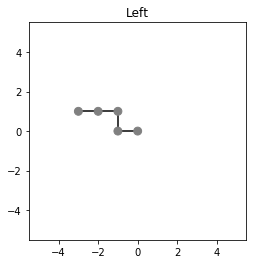

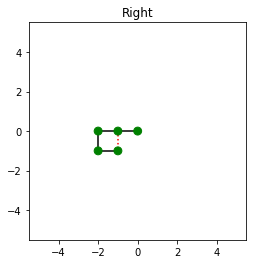

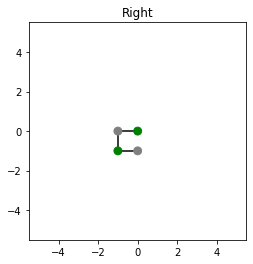

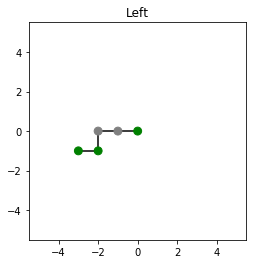

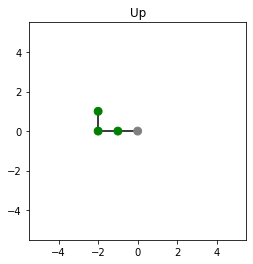

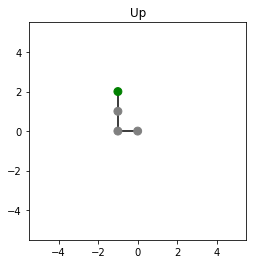

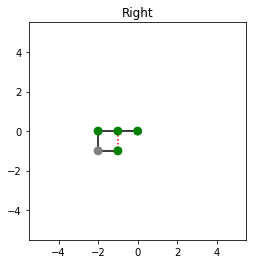

In [45]:
# Sequences with max length 5

minitestseqs = random.sample(seqs, 10)
for s in minitestseqs:
    env = HP2D(s[:-1], (10,11,11))
    tenv = Lattice2DLinearEnv(s[:-1])
    tenv.reset()
    state = env.make_state()
    for t in range(len(s) - 2):
        mcts   = MCTS(env, test_model, 300, cpuct = 5)
        pi     = mcts.get_prob(state, temp = 0)
        action = np.random.choice(len(pi), p = pi)
        state  = env.next_state(state, action)    
        tenv.step(action)
    tenv.render()
    print(env.calc_score(state))

In [40]:
async def train():
    criterion = AlphaLoss()
    optimizer = optim.Adam(test_model.parameters(), lr = 0.001)
    loss = []
    for _ in range(10):
        loss.append(compute_loss(test_model, batch_size, replay_buffer, optimizer, criterion))
    return loss

In [41]:
async def play(num_iter, num_games):
    '''
    Plays num_games games with the current network.
    For each game, adds len(seq) - 1 data points (s_t, pi_t, z_t) to replay buffer.
    '''
    for g in range(num_games):
        seq = random.sample(train_seqs, 1)[0][:-1]
        # print("Game {} / {}: {}".format(g + 1, num_games, seq))
        env = HP2D(seq, (10,11,11))
        states = []
        probs = []
        state = env.make_state()
        for t in range(len(seq) - 1):
            temp = int(t < len(seq) // 10)
            mcts = MCTS(env, test_model, num_iter, cpuct = 5)
            pi_t = mcts.get_prob(state, temp = temp)
            sym = get_syms(state, pi_t)
            for s, p in sym:
                states.append(s)
                probs.append(p)
            action = np.random.choice(len(pi_t), p = pi_t)
            state = env.next_state(state, action)
        reward = env.calc_score(states[-1])
        for i in range(len(states)):
            replay_buffer.push(states[i], probs[i], reward)

In [42]:
async def evaluate(num_iter):
    '''
    Evaluates using 10 games with current network, compare results to hypothetical maximum.
    Returns a float between (0, 1): score / hyp_max score
    '''
    seqs = test_seqs
    total = 0
    for s in seqs:
        env = HP2D(s[:-1], (10,11,11))
        state = env.make_state()
        for t in range(len(s) - 1):
            mcts   = MCTS(env, test_model, num_iter, cpuct = 5)
            pi     = mcts.get_prob(state, temp = 0)
            action = np.random.choice(len(pi), p = pi)
            state  = env.next_state(state, action)    
        total += env.calc_score(state)
    return total / 10

In [43]:
def get_syms(state, pi):
    """
    Input:
        board: current board
        pi: policy vector of size self.get_prob()
    Returns:
        symmForms: a list of [(board,pi)] where each tuple is a symmetrical
                   form of the board and the corresponding pi vector. This
                   is used when training the neural network from examples.
    """
    assert(len(pi) == 4)
    l = []
    
    def rotate(pi, n):
        for _ in range(n):
            temp = pi
            pi = [temp[1], temp[3], temp[0], temp[2]]
        return pi
    
    def flip(pi):
        return [pi[3], pi[1], pi[2], pi[0]]
        
    for i in range(1, 5):
        for j in [True, False]:
            new_state = np.rot90(state, i, (1, 2))
            new_pi = rotate(pi, i)
            if j:
                new_state = np.fliplr(new_state)
                new_pi = flip(new_pi)
            l += [(new_state, new_pi)]
    return l

In [44]:
async def main(num_timesteps, num_games, num_iter, batch_size):
    '''
    Executing play, train, evaluate asynchronously in parallel.
    '''

    losses = []
    scores = []

    for ts in tqdm(range(1, num_timesteps + 1)):
        # clear_output(wait = True)
        # print('Timestep {} / {}'.format(ts, num_timesteps))
        flag = False
        
        # Data generation
        playing = loop.create_task(play(num_iter, num_games))

        # Update params
        if len(replay_buffer) > batch_size:
            training = loop.create_task(train())
            flag = True
        
        # Evaluate agent
        if ts % 200 == 0:
            evaluating = loop.create_task(evaluate(num_iter))
            await asyncio.wait([playing, training, evaluating])
            
            score = evaluating.result()
            scores.append(score)
        else:
            if flag:
                await asyncio.wait([playing, training])
            
                loss = training.result()
                losses.append(loss)
            else:
                await asyncio.wait([playing])

    return losses, scores

In [ ]:
num_timesteps = 100
num_games = 15
num_iter = 10
batch_size = 32

loop = asyncio.get_event_loop()

losses, scores = loop.run_until_complete(main(num_timesteps, num_games, num_iter, batch_size))

In [ ]:
# torch.save(dualres.state_dict(), 'PFZeroNet.pt')

In [ ]:
# model = DualRes(10, 4, USE_CUDA)
# if USE_CUDA:
#     model = model.cuda()
# model.load_state_dict(torch.load('PFZeroNet.pt'))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10, 5))
ax = plt.subplot(1,2,1)
plt.plot(losses)
ax = plt.subplot(1,2,2)
plt.plot(scores)